<a href="https://colab.research.google.com/github/hssa83/dual-threshold-liquefaction-rf/blob/main/SF_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade pip
!pip install --quiet pandas numpy openpyxl xlsxwriter pyarrow
!pip install --quiet scikit-learn scikit-plot matplotlib shap
!pip install --quiet PyALE
import warnings, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap
from PyALE import ale
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     RandomizedSearchCV)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score,
                             brier_score_loss, roc_curve, confusion_matrix)

warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.dpi"] = 120
print("✓ All libraries installed and imported")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00
✓ All libraries installed and imported


In [ ]:
import pandas as pd
file_path = "Liquefaction Clean Data .xlsx"
df = pd.read_excel(file_path)
rename_map = {
    "N1,60,CS"   : "N1_60_cs",
    "CSR*eq"     : "CSR_star",
    "σᵥ′ (psf)"  : "sigma_v_eff",
    "MW"         : "Mw",
    "FC (%)"     : "FC",
    "L"          : "Liquefied",
    "Data Class" : "Quality",
}
df = df.rename(columns=rename_map)
num_cols = ["N1_60_cs", "CSR_star", "sigma_v_eff", "FC", "Mw"]
desc = (df[num_cols]
        .describe()
        .T
        .rename(columns={"std": "Std", "50%": "Median"}))

class_counts = (df["Liquefied"]
                .value_counts()
                .rename(index={0: "Non-liq", 1: "Liq"})
                .to_frame("Count"))

with pd.ExcelWriter("table_1_descriptive.xlsx", engine="xlsxwriter") as xl:
    desc.to_excel(xl, sheet_name="Descriptive", index_label="Variable")
    class_counts.to_excel(xl, sheet_name="ClassCounts")
df[["N1_60_cs", "CSR_star", "Liquefied"]].to_excel(
    "figure_1_scatter_data.xlsx", index=False)

print("✓ Table 1   → table_1_descriptive.xlsx")
print("✓ Fig 1 data→ figure_1_scatter_data.xlsx")
print("Shape:", df.shape)
print("Columns:", list(df.columns))




✓ Table 1   → table_1_descriptive.xlsx
✓ Fig 1 data→ figure_1_scatter_data.xlsx
Shape: (208, 7)
Columns: ['N1_60_cs', 'Mw', 'FC', 'sigma_v_eff', 'CSR_star', 'Liquefied', 'Quality']


In [ ]:
from scipy.stats import randint
weight_map = {"A": 1.0, "B": 0.70, "C": 0.40}
df["Weight"] = df["Quality"].map(weight_map)
predictors = ["N1_60_cs", "CSR_star", "sigma_v_eff", "FC", "Mw"]
X, y, w = df[predictors], df["Liquefied"], df["Weight"]
X_tr, X_te, y_tr, y_te, w_tr, w_te = train_test_split(
    X, y, w, test_size=0.20, stratify=y, random_state=42)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")
param_dist = {
    "n_estimators"     : randint(60, 301),
    "max_depth"        : [None] + list(range(3, 16)),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf" : randint(1, 11),
    "max_features"     : ["sqrt", "log2", None],
    "bootstrap"        : [True, False],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1,
)
rs.fit(X_tr, y_tr, sample_weight=w_tr)
best_rf = rs.best_estimator_
cv_results = pd.DataFrame(rs.cv_results_)
with pd.ExcelWriter("table_S1_hyperparam_search.xlsx", engine="xlsxwriter") as xl:
    cv_results.to_excel(xl, sheet_name="All_Trials", index=False)
    pd.DataFrame([rs.best_params_]).to_excel(xl, sheet_name="Best_Params", index=False)

print("✓ Hyper-parameter search complete")
print("Best params →", rs.best_params_)
print("Saved → table_S1_hyperparam_search.xlsx")


Train: (166, 5), Test: (42, 5)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
✓ Hyper-parameter search complete
Best params → {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 75}
Saved → table_S1_hyperparam_search.xlsx


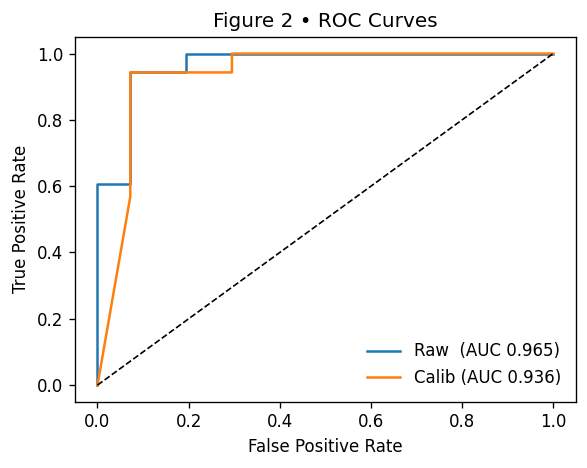

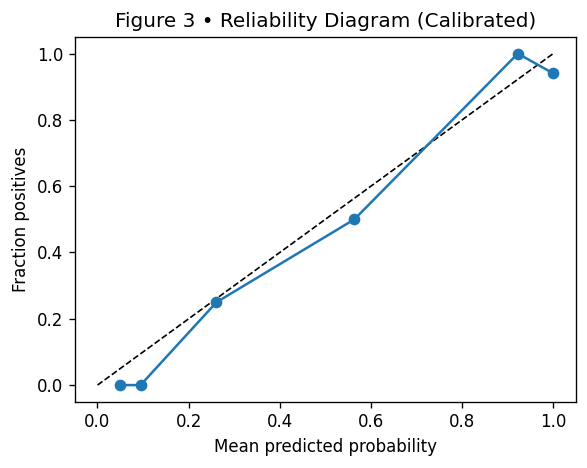

✓ Table 2 & Figures 2-3 data saved as Excel files


In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, f1_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
iso = CalibratedClassifierCV(best_rf, method="isotonic", cv=5)
iso.fit(X_tr, y_tr, sample_weight=w_tr)

proba_raw = best_rf.predict_proba(X_te)[:, 1]
proba_cal = iso.predict_proba(X_te)[:, 1]
fpr_raw, tpr_raw, thr_raw = roc_curve(y_te, proba_raw, sample_weight=w_te)
fpr_cal, tpr_cal, thr_cal = roc_curve(y_te, proba_cal, sample_weight=w_te)

auc_raw = roc_auc_score(y_te, proba_raw, sample_weight=w_te)
auc_cal = roc_auc_score(y_te, proba_cal, sample_weight=w_te)
opt_raw_idx = np.argmax(tpr_raw - fpr_raw)
opt_cal_idx = np.argmax(tpr_cal - fpr_cal)
thr_opt_raw, thr_opt_cal = thr_raw[opt_raw_idx], thr_cal[opt_cal_idx]

def metrics_at_thresh(y_true, probs, thr, w=None):
    pred = (probs >= thr).astype(int)
    acc   = accuracy_score(y_true, pred, sample_weight=w)
    f1    = f1_score(y_true, pred, sample_weight=w)
    brier = brier_score_loss(y_true, probs, sample_weight=w)
    cm    = confusion_matrix(y_true, pred, sample_weight=w)
    return acc, f1, brier, cm

acc_raw, f1_raw, brier_raw, cm_raw = metrics_at_thresh(y_te, proba_raw,
                                                       thr_opt_raw, w_te)
acc_cal, f1_cal, brier_cal, cm_cal = metrics_at_thresh(y_te, proba_cal,
                                                       thr_opt_cal, w_te)
tab2 = pd.DataFrame({
    "Model"        : ["RF_raw", "RF_calibrated"],
    "AUC"          : [auc_raw, auc_cal],
    "Acc"          : [acc_raw, acc_cal],
    "F1"           : [f1_raw,  f1_cal],
    "Brier"        : [brier_raw, brier_cal],
    "Opt_threshold": [thr_opt_raw, thr_opt_cal],
})
tab2.to_excel("table_2_metrics.xlsx", index=False)
with pd.ExcelWriter("figure_2_roc_data.xlsx", engine="xlsxwriter") as xl:
    pd.DataFrame({"fpr": fpr_raw, "tpr": tpr_raw,
                  "threshold": thr_raw}).to_excel(xl, sheet_name="Raw",
                                                   index=False)
    pd.DataFrame({"fpr": fpr_cal, "tpr": tpr_cal,
                  "threshold": thr_cal}).to_excel(xl, sheet_name="Calibrated",
                                                   index=False)
prob_true, prob_pred = calibration_curve(y_te, proba_cal, n_bins=10,
                                         strategy="quantile")
pd.DataFrame({"bin_pred_mean": prob_pred,
              "bin_true_fraction": prob_true}
            ).to_excel("figure_3_reliability_data.xlsx", index=False)
plt.figure(figsize=(5, 4))
plt.plot(fpr_raw, tpr_raw, label=f"Raw  (AUC {auc_raw:.3f})")
plt.plot(fpr_cal, tpr_cal, label=f"Calib (AUC {auc_cal:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate");  plt.ylabel("True Positive Rate")
plt.title("Figure 2 • ROC Curves")
plt.legend(frameon=False); plt.tight_layout(); plt.show()
plt.figure(figsize=(5, 4))
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.plot(prob_pred, prob_true, marker="o")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction positives")
plt.title("Figure 3 • Reliability Diagram (Calibrated)")
plt.tight_layout(); plt.show()

print("✓ Table 2 & Figures 2-3 data saved as Excel files")


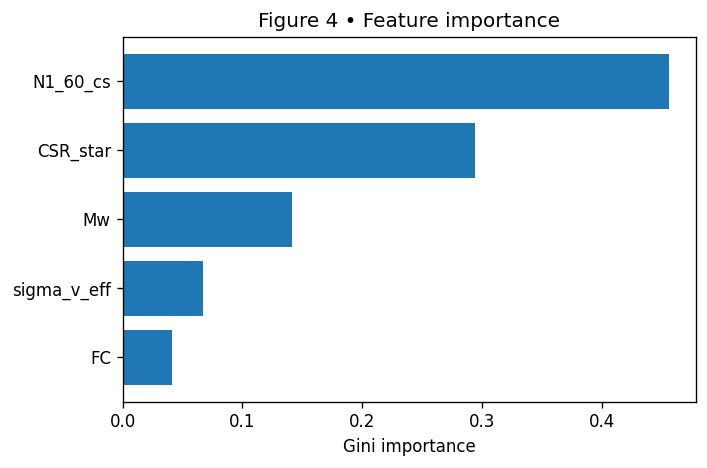

✓ Saved → figure_4_importance.xlsx  (data for Figure 4)


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap, warnings

predictors = ["N1_60_cs", "CSR_star", "sigma_v_eff", "FC", "Mw"]
gini = best_rf.feature_importances_
use_shap = True
try:
    explainer   = shap.TreeExplainer(best_rf)
    shap_sample = X_tr.sample(n=min(1000, len(X_tr)), random_state=42)
    shap_vals   = explainer.shap_values(shap_sample)[1]         # class-1
    shap_mean   = np.abs(shap_vals).mean(axis=0)
    if len(shap_mean) != len(gini):
        raise ValueError("SHAP length mismatch")
except Exception as e:
    warnings.warn(f"SHAP unavailable → using Gini only ({e})")
    use_shap = False
if use_shap:
    imp_df = pd.DataFrame({
        "Feature"         : predictors,
        "Gini_importance" : gini,
        "SHAP_abs_mean"   : shap_mean
    }).sort_values("SHAP_abs_mean", ascending=False)
    bar_height = imp_df["SHAP_abs_mean"]
    xlabel     = "Mean |SHAP value|"
else:
    imp_df = pd.DataFrame({
        "Feature"         : predictors,
        "Gini_importance" : gini
    }).sort_values("Gini_importance", ascending=False)
    bar_height = imp_df["Gini_importance"]
    xlabel     = "Gini importance"
imp_df.to_excel("figure_4_importance.xlsx", index=False)
plt.figure(figsize=(6, 4))
plt.barh(imp_df["Feature"], bar_height)
plt.gca().invert_yaxis()
plt.xlabel(xlabel)
plt.title("Figure 4 • Feature importance")
plt.tight_layout()
plt.show()

print("✓ Saved → figure_4_importance.xlsx  (data for Figure 4)")


In [ ]:
!pip install --quiet --upgrade --force-reinstall PyALE==1.2.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21/21 [PyALE]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have panda

In [ ]:
def pdp_on_grid(model, med_row, feat, grid_like):
    grid = pd.to_numeric(grid_like, errors="coerce").astype(float)
    grid = grid[np.isfinite(grid)]
    base = np.tile(med_row.to_numpy(dtype=float), (len(grid), 1))
    X_tmp = pd.DataFrame(base, columns=med_row.index)
    X_tmp[feat] = grid
    return model.predict_proba(X_tmp)[:, 1], grid

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

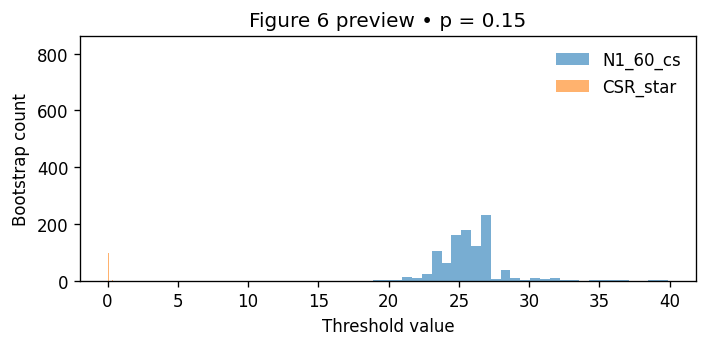

✓ Table 3 → table_3_thresholds.xlsx
✓ Figure 6 data → figure_6_boot_histograms.xlsx


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

primary_vars = ["N1_60_cs", "CSR_star"]
TARGET_PROBS = [0.05, 0.15, 0.50]
N_BOOT       = 1000
GRID_PTS     = 200
rng          = np.random.default_rng(42)
X_med = X.median()
def pdp_numeric(model, med_row, feat, grid):
    base = np.tile(med_row.values.astype(float), (len(grid), 1))
    X_tmp = pd.DataFrame(base, columns=med_row.index)
    X_tmp[feat] = grid
    return model.predict_proba(X_tmp)[:, 1]
boot_store = {var: {p: [] for p in TARGET_PROBS} for var in primary_vars}
for _ in trange(N_BOOT, desc="Bootstrapping"):
    idx = rng.choice(len(X_tr), size=len(X_tr), replace=True)
    X_b, y_b, w_b = X_tr.iloc[idx], y_tr.iloc[idx], w_tr.iloc[idx]
    rf_b  = RandomForestClassifier(**best_rf.get_params())
    rf_b.fit(X_b, y_b, sample_weight=w_b)
    iso_b = CalibratedClassifierCV(rf_b, method="isotonic", cv=5)
    iso_b.fit(X_b, y_b, sample_weight=w_b)

    for var in primary_vars:
        grid  = np.linspace(X[var].min(), X[var].max(), GRID_PTS)
        probs = pdp_numeric(iso_b, X_med, var, grid)

        for p in TARGET_PROBS:

            thr = grid[np.argmin(np.abs(probs - p))]
            boot_store[var][p].append(thr)

rows = []
for var in primary_vars:
    for p in TARGET_PROBS:
        arr = np.array(boot_store[var][p])
        rows.append({
            "Variable" : var,
            "P_target" : p,
            "Median"   : np.median(arr),
            "CI_lower" : np.percentile(arr, 5),
            "CI_upper" : np.percentile(arr, 95)
        })
table3 = pd.DataFrame(rows)
table3.to_excel("table_3_thresholds.xlsx", index=False)
with pd.ExcelWriter("figure_6_boot_histograms.xlsx", engine="xlsxwriter") as xl:
    for var in primary_vars:
        pd.DataFrame(boot_store[var]).to_excel(xl, sheet_name=var, index=False)
plt.figure(figsize=(6,3))
for var in primary_vars:
    plt.hist(boot_store[var][0.15], bins=30, alpha=0.6, label=var)
plt.xlabel("Threshold value"); plt.ylabel("Bootstrap count")
plt.title("Figure 6 preview • p = 0.15"); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

print("✓ Table 3 → table_3_thresholds.xlsx")
print("✓ Figure 6 data → figure_6_boot_histograms.xlsx")


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score,
                             precision_score, recall_score)

P_TARGET = 0.15

thr_table = table3
thr_N1  = thr_table.query("Variable == 'N1_60_cs' & P_target == @P_TARGET")["Median"].iat[0]
thr_CSR = thr_table.query("Variable == 'CSR_star' & P_target == @P_TARGET")["Median"].iat[0]
print(f"Dual-rule thresholds @ P={P_TARGET:0.2f}: "
      f"N1_thr = {thr_N1:.2f}  |  CSR_thr = {thr_CSR:.3f}")

y_true = y_te.values
w_true = w_te.values
y_pred = ((X_te["N1_60_cs"] <= thr_N1) & (X_te["CSR_star"] >= thr_CSR)).astype(int)
cm = confusion_matrix(y_true, y_pred, sample_weight=w_true)
acc  = accuracy_score (y_true, y_pred, sample_weight=w_true)
prec = precision_score(y_true, y_pred, sample_weight=w_true, zero_division=0)
rec  = recall_score   (y_true, y_pred, sample_weight=w_true)
f1   = f1_score       (y_true, y_pred, sample_weight=w_true)
with pd.ExcelWriter("table_4_dual_rule.xlsx", engine="xlsxwriter") as xl:

    pd.DataFrame(cm,
                 index=["True Non-liq", "True Liq"],
                 columns=["Pred Non-liq", "Pred Liq"]
                ).to_excel(xl, sheet_name="ConfusionMatrix")

    pd.DataFrame([{
        "Accuracy" : acc,
        "Precision": prec,
        "Recall"   : rec,
        "F1_score" : f1
    }]).to_excel(xl, sheet_name="Metrics", index=False)

print("✓ Table 4 workbook → 'table_4_dual_rule.xlsx'")

pd.set_option("display.precision", 3)
display(pd.DataFrame(cm,
                     index=["True Non-liq", "True Liq"],
                     columns=["Pred Non-liq", "Pred Liq"]))
print(f"Accuracy = {acc:.3f}    F1 = {f1:.3f}    Precision = {prec:.3f}    Recall = {rec:.3f}")


Dual-rule thresholds @ P=0.15: N1_thr = 25.66  |  CSR_thr = 0.029
✓ Table 4 workbook → 'table_4_dual_rule.xlsx'


,Pred Non-liq,Pred Liq
True Non-liq,5.6,8.3
True Liq,0.0,17.6


Accuracy = 0.737    F1 = 0.809    Precision = 0.680    Recall = 1.000


/tmp/ipython-input-10-597552895.py:75: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({var: grid, "PDP_prob": pdp}).to_excel(xl, "PDP", index=False)
/tmp/ipython-input-10-597552895.py:76: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({var: mids, "ALE": ale}).to_excel(xl, "ALE", index=False)


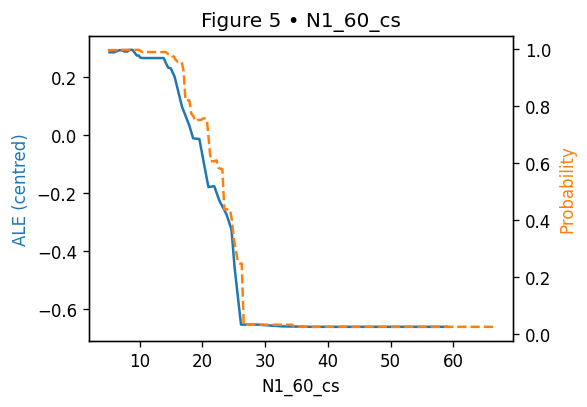

/tmp/ipython-input-10-597552895.py:75: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({var: grid, "PDP_prob": pdp}).to_excel(xl, "PDP", index=False)
/tmp/ipython-input-10-597552895.py:76: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({var: mids, "ALE": ale}).to_excel(xl, "ALE", index=False)


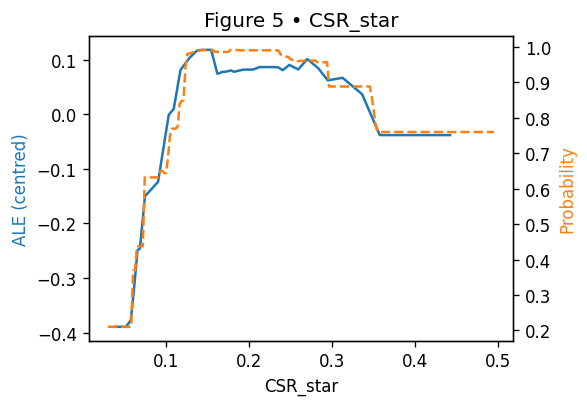

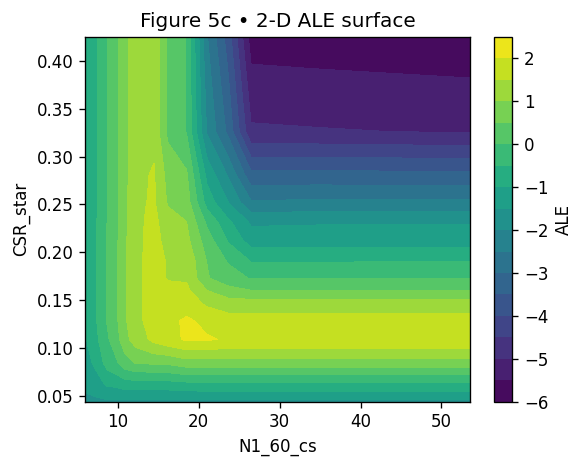

✓ Figure 5 workbooks saved:
   figure_5_N1_60_cs_ale_pdp.xlsx
   figure_5_CSR_star_ale_pdp.xlsx
   figure_5c_ale_surface.xlsx


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

PRIMARY  = ["N1_60_cs", "CSR_star"]
BINS_1D  = 40
GRID2D   = 15
WORKBOOKS = []

def ale_1d(model, X_df, feat, n_bins):
    """Return (grid_midpoints, centred_ALE) for one feature."""
    x = X_df[feat].to_numpy(float)
    edges = np.quantile(x, np.linspace(0, 1, n_bins + 1))
    mids  = 0.5 * (edges[:-1] + edges[1:])
    eff   = np.zeros(n_bins)

    for k in range(n_bins):
        in_k   = (x >= edges[k])   & (x < edges[k+1])
        in_km1 = (x >= edges[k-1]) & (x < edges[k]) if k else in_k
        if not in_k.any() or not in_km1.any():
            continue

        X_hi, X_lo = X_df.copy(), X_df.copy()
        X_hi.loc[in_k,  feat] = edges[k+1]
        X_lo.loc[in_k,  feat] = edges[k]
        p_hi = model.predict_proba(X_hi)[:,1][in_k].mean()
        p_lo = model.predict_proba(X_lo)[:,1][in_k].mean()
        eff[k] = p_hi - p_lo

    ale = np.cumsum(eff)
    ale -= ale.mean()
    return mids, ale

X_med = X.median()
def pdp_1d(model, feat, grid):
    X_tmp = pd.DataFrame(np.repeat(X_med.values[None,:], len(grid), 0),
                         columns=X_med.index)
    X_tmp[feat] = grid
    return model.predict_proba(X_tmp)[:,1]

def ale_2d(model, X_df, f1, f2, g1_pts, g2_pts):
    edges1 = np.quantile(X_df[f1], np.linspace(0,1,g1_pts+1))
    edges2 = np.quantile(X_df[f2], np.linspace(0,1,g2_pts+1))
    fx = np.zeros((g1_pts, g2_pts))

    for i in range(g1_pts):
        for j in range(g2_pts):
            in_ij = ((X_df[f1]>=edges1[i])&(X_df[f1]<edges1[i+1])&
                     (X_df[f2]>=edges2[j])&(X_df[f2]<edges2[j+1]))
            if not in_ij.any(): continue
            # delta in f1
            X_hi, X_lo = X_df.copy(), X_df.copy()
            X_hi.loc[in_ij, f1] = edges1[i+1]
            X_lo.loc[in_ij, f1] = edges1[i]
            d1 = model.predict_proba(X_hi)[:,1][in_ij].mean() - \
                 model.predict_proba(X_lo)[:,1][in_ij].mean()
            # delta in f2
            Y_hi, Y_lo = X_df.copy(), X_df.copy()
            Y_hi.loc[in_ij, f2] = edges2[j+1]
            Y_lo.loc[in_ij, f2] = edges2[j]
            d2 = model.predict_proba(Y_hi)[:,1][in_ij].mean() - \
                 model.predict_proba(Y_lo)[:,1][in_ij].mean()
            fx[i,j] = d1 + d2

    surf = fx.cumsum(0).cumsum(1)
    surf -= surf.mean()
    mids1 = 0.5*(edges1[:-1]+edges1[1:]); mids2 = 0.5*(edges2[:-1]+edges2[1:])
    return mids1, mids2, surf

for var in PRIMARY:
    grid = np.linspace(X[var].min(), X[var].max(), 200)
    pdp  = pdp_1d(iso, var, grid)
    mids, ale = ale_1d(iso, X, var, BINS_1D)

    out = f"figure_5_{var}_ale_pdp.xlsx"
    with pd.ExcelWriter(out, engine="xlsxwriter") as xl:
        pd.DataFrame({var: grid, "PDP_prob": pdp}).to_excel(xl, "PDP", index=False)
        pd.DataFrame({var: mids, "ALE": ale}).to_excel(xl, "ALE", index=False)
    WORKBOOKS.append(out)

    # preview
    fig, ax1 = plt.subplots(figsize=(5,3.5))
    ax1.plot(mids, ale, color="C0", label="ALE")
    ax1.set_xlabel(var); ax1.set_ylabel("ALE (centred)", color="C0")
    ax2 = ax1.twinx()
    ax2.plot(grid, pdp, ls="--", color="C1", label="PDP")
    ax2.set_ylabel("Probability", color="C1")
    ax1.set_title(f"Figure 5 • {var}")
    fig.tight_layout(); plt.show()

# 2-D ALE surface
g1_mids, g2_mids, surf = ale_2d(iso, X, *PRIMARY, GRID2D, GRID2D)
out2 = "figure_5c_ale_surface.xlsx"
pd.DataFrame({PRIMARY[0]: np.repeat(g1_mids, len(g2_mids)),
              PRIMARY[1]: np.tile(g2_mids, len(g1_mids)),
              "ALE": surf.ravel()}
            ).to_excel(out2, index=False)
WORKBOOKS.append(out2)

plt.figure(figsize=(5,4))
cs = plt.contourf(g1_mids, g2_mids, surf.T, levels=15)
plt.colorbar(cs, label="ALE"); plt.xlabel(PRIMARY[0]); plt.ylabel(PRIMARY[1])
plt.title("Figure 5c • 2-D ALE surface"); plt.tight_layout(); plt.show()

print("✓ Figure 5 workbooks saved:")
for wb in WORKBOOKS:
    print("  ", wb)


In [ ]:
import pandas as pd

P_LEVELS = [0.05, 0.15, 0.50]

rows = []
for p in P_LEVELS:
    thr_N1  = table3.query("Variable=='N1_60_cs' & P_target==@p")["Median"].iat[0]
    thr_CSR = table3.query("Variable=='CSR_star' & P_target==@p")["Median"].iat[0]

    rows.append({
        "Line_ID" : f"P{int(p*100)}_Vert",
        "X1"      : thr_N1,         "Y1" : 0.05,
        "X2"      : thr_N1,         "Y2" : 0.45
    })
    rows.append({
        "Line_ID" : f"P{int(p*100)}_Horz",
        "X1"      : 3,              "Y1" : thr_CSR,
        "X2"      : 40,             "Y2" : thr_CSR
    })

overlay = pd.DataFrame(rows)
overlay.to_excel("figure_7_overlay_lines.xlsx", index=False)

print("✓ Overlay workbook saved → 'figure_7_overlay_lines.xlsx'")
for p in P_LEVELS:
    n1  = table3.query("Variable=='N1_60_cs' & P_target==@p")["Median"].iat[0]
    csr = table3.query("Variable=='CSR_star' & P_target==@p")["Median"].iat[0]
    print(f"  P={p:.2f}  →  N1_thr={n1:.2f}  |  CSR_thr={csr:.3f}")


✓ Overlay workbook saved → 'figure_7_overlay_lines.xlsx'
  P=0.05  →  N1_thr=26.59  |  CSR_thr=0.029
  P=0.15  →  N1_thr=25.66  |  CSR_thr=0.029
  P=0.50  →  N1_thr=23.19  |  CSR_thr=0.072


✓ Saved → figure_S2_weight_sensitivity.xlsx


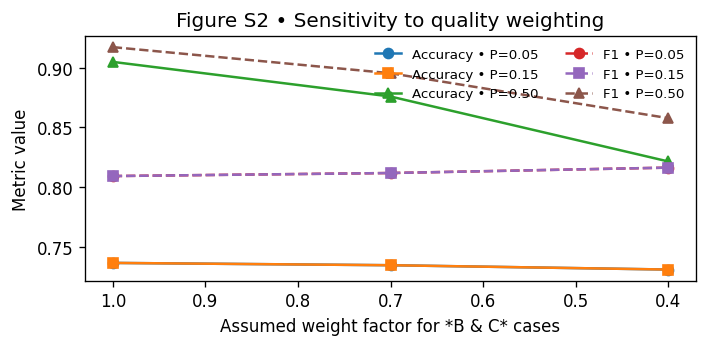

In [ ]:
# ────────────────────────────────────────────────────────────────
# Figure S2 • Sensitivity to quality weighting  (updated logic)
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

P_LEVELS    = [0.05, 0.15, 0.50]
WEIGHTS_ALL = [1.0, 0.70, 0.40]   # scaling factors to apply to B & C only

records = []

def dual_rule(Xdf, n1_thr, csr_thr):
    return ((Xdf["N1_60_cs"] <= n1_thr) & (Xdf["CSR_star"] >= csr_thr)).astype(int)

for w_fac in WEIGHTS_ALL:
    # --- NEW: rescale B & C (weights < 1.0) relative to A-class (weight = 1.0)
    w_tmp = w_te.copy()            # w_te is the Series returned by train_test_split
    mask  = w_tmp < 1.0            # rows belonging to classes B or C
    w_tmp[mask] = w_tmp[mask] * w_fac
    w_tmp = w_tmp.to_numpy()       # scikit-learn expects a NumPy array
    # ------------------------------------------------------------------------

    for p in P_LEVELS:
        n1_thr  = table3.query("Variable=='N1_60_cs' & P_target==@p")["Median"].iat[0]
        csr_thr = table3.query("Variable=='CSR_star' & P_target==@p")["Median"].iat[0]

        y_hat = dual_rule(X_te, n1_thr, csr_thr)
        records.append({
            "Weight_factor": w_fac,
            "P_level": p,
            "Accuracy": accuracy_score(y_te, y_hat, sample_weight=w_tmp),
            "F1":       f1_score     (y_te, y_hat, sample_weight=w_tmp, zero_division=0)
        })

df_S2 = pd.DataFrame(records)
df_S2.to_excel("figure_S2_weight_sensitivity.xlsx", index=False)
print("✓ Saved → figure_S2_weight_sensitivity.xlsx")

# ---------------- plot preview (unchanged) ----------------------
plt.figure(figsize=(6,3))
markers = {0.05:"o", 0.15:"s", 0.50:"^"}
for metric, style in [("Accuracy","-"), ("F1","--")]:
    for p in P_LEVELS:
        subset = df_S2[df_S2["P_level"] == p]
        plt.plot(subset["Weight_factor"], subset[metric],
                 linestyle=style, marker=markers[p],
                 label=f"{metric} • P={p:.2f}")
plt.gca().invert_xaxis()
plt.xlabel("Assumed weight factor for *B & C* cases")
plt.ylabel("Metric value")
plt.title("Figure S2 • Sensitivity to quality weighting")
plt.legend(frameon=False, ncol=2, fontsize=8)
plt.tight_layout(); plt.show()



           0.05      0.15      0.50
count  1000.000  1000.000  1000.000
mean     27.521    25.739    22.851
std       3.029     2.126     1.940
min      21.023    18.859    17.004
25%      25.659    24.732    21.332
50%      26.586    25.659    23.186
75%      28.441    26.586    24.113
max      42.349    39.877    26.895


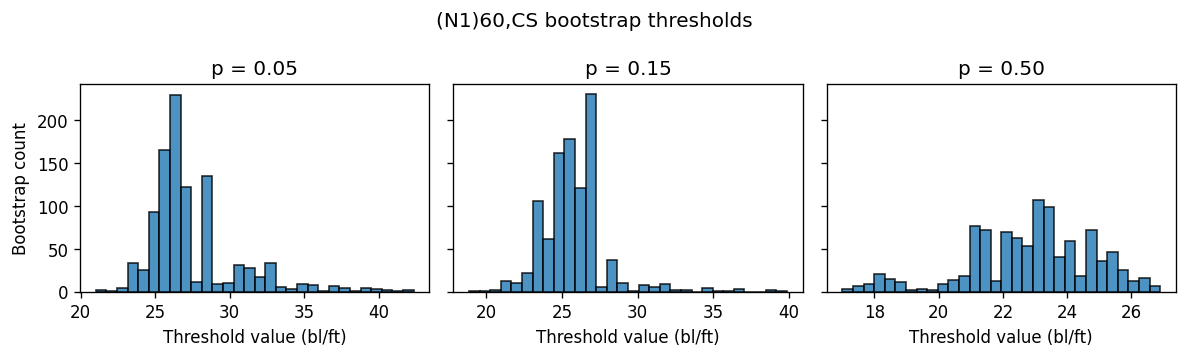

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("figure_6_boot_histograms.xlsx", sheet_name="N1_60_cs")

print(df.describe())

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

prob_levels = [0.05, 0.15, 0.50]
for ax, p in zip(axes, prob_levels):
    ax.hist(df[p], bins=30, edgecolor="k", alpha=0.8)
    ax.set_xlabel("Threshold value (bl/ft)")
    ax.set_title(f"p = {p:.2f}")
axes[0].set_ylabel("Bootstrap count")
fig.suptitle("(N1)60,CS bootstrap thresholds")
plt.tight_layout(); plt.show()


           0.05      0.15      0.50
count  1000.000  1000.000  1000.000
mean      0.032     0.037     0.076
std       0.017     0.021     0.035
min       0.029     0.029     0.029
25%       0.029     0.029     0.062
50%       0.029     0.029     0.072
75%       0.029     0.029     0.090
max       0.355     0.355     0.374


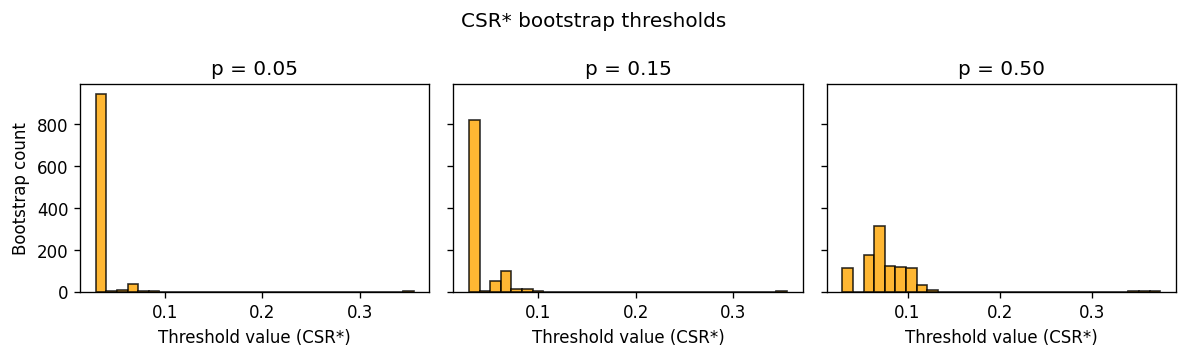

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_csr = pd.read_excel("figure_6_boot_histograms.xlsx", sheet_name="CSR_star")

print(df_csr.describe())

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

prob_levels = [0.05, 0.15, 0.50]
for ax, p in zip(axes, prob_levels):
    ax.hist(df_csr[p], bins=30, edgecolor="k", alpha=0.8, color="orange")
    ax.set_xlabel("Threshold value (CSR*)")
    ax.set_title(f"p = {p:.2f}")
axes[0].set_ylabel("Bootstrap count")
fig.suptitle("CSR* bootstrap thresholds")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd, numpy as np
from pathlib import Path

workbook = "figure_6_boot_histograms.xlsx"
if not Path(workbook).exists():
    workbook = "/mnt/data/figure_6_boot_histograms.xlsx"

sheets = {"N1_60_cs": "(N1)60_CS", "CSR_star": "CSR_star"}
prob_levels, n_bins = [0.05, 0.15, 0.50], 30

def build_hist(series, bins=30):
    cnts, edges = np.histogram(series.dropna(), bins=bins)
    return pd.DataFrame(dict(
        Bin_left = edges[:-1],
        Bin_right= edges[1:],
        Bin_mid  = 0.5*(edges[:-1] + edges[1:]),
        Count    = cnts))

if not Path(workbook).exists():
    print("❌  Workbook not found — check the path and re-run.")
else:
    print("Using:", workbook)
    for sheet, tag in sheets.items():
        df   = pd.read_excel(workbook, sheet_name=sheet)
        out  = f"histograms_{tag}.xlsx"
        with pd.ExcelWriter(out, engine="xlsxwriter") as xl:
            for p in prob_levels:
                build_hist(df[p], n_bins).to_excel(xl, sheet_name=f"p_{p:.2f}", index=False)
        print("   ✓ exported", out)


Using: figure_6_boot_histograms.xlsx
   ✓ exported histograms_(N1)60_CS.xlsx
   ✓ exported histograms_CSR_star.xlsx


In [ ]:
!zip -r results_bundle.zip .


  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.07.10/ (stored 0%)
  adding: .config/logs/2025.07.10/13.34.37.820504.log (deflated 58%)
  adding: .config/logs/2025.07.10/13.33.45.486303.log (deflated 92%)
  adding: .config/logs/2025.07.10/13.34.38.537881.log (deflated 57%)
  adding: .config/logs/2025.07.10/13.34.29.179991.log (deflated 58%)
  adding: .config/logs/2025.07.10/13.34.14.671755.log (deflated 58%)
  adding: .config/logs/2025.07.10/13.34.23.548658.log (deflated 86%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/.last_update_check.json (deflated 24%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/default_confi